In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.layers import Dropout
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import glob
#!pip install tqdm
from tqdm import tqdm
import random
from matplotlib import pyplot as plt

import os

In [ ]:
# loading the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
nbClasses = np.unique(y_train).shape[0]
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# preprocessings
x_train = x_train.astype('float32') / 255. # 2D images
x_test = x_test.astype('float32') / 255.

size = len(x_train[0])
print(size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
32


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
VGGmodel = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
VGGmodel.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m)
# and add a fully-connected layer
m = Dense(1024, activation='relu')(m)
m = Dense(512, activation='relu')(m)
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation='softmax')(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,769,930 (60.16 MB)

 Trainable params: 15,769,930 (60.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training
ourCallback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=8, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
batch_size = 128
epochs = 28

# training part I: training only the classification part (the end)
for layer in VGGmodel.layers:
    layer.trainable = False
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[ourCallback],verbose=1)

Epoch 1/28
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.4562 - loss: 1.5380 - val_accuracy: 0.5684 - val_loss: 1.2161
Epoch 2/28
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5887 - loss: 1.1548 - val_accuracy: 0.5986 - val_loss: 1.1419
Epoch 3/28
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6297 - loss: 1.0568 - val_accuracy: 0.6086 - val_loss: 1.1311
Epoch 4/28
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6543 - loss: 0.9820 - val_accuracy: 0.6118 - val_loss: 1.1259
Epoch 5/28
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6835 - loss: 0.9015 - val_accuracy: 0.6089 - val_loss: 1.1193
Epoch 6/28
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6968 - loss: 0.8554 - val_accuracy: 0.6231 - val_loss: 1.1108
Epoch 7/28
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7187 - loss: 0.7921 - val_accuracy: 0.6154 - val_loss: 1.1273
Epoch 8/28
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7410 - loss: 0.7419 - val

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
tp_data_root = "/content/drive/My Drive/tp_pgd/"
model_weight_filename = "pgd_cifar_10.weights.h5"

In [ ]:
# model.save_weights(os.path.join(tp_data_root, model_weight_filename))

In [ ]:
model.load_weights(os.path.join(tp_data_root, model_weight_filename))

In [ ]:
def create_adversarial_pattern(input_image, input_label, model):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    with tf.GradientTape() as tape:
        # input_image = np.array(input_image)
        if (tf.is_tensor(input_image)):
          input_image = input_image.numpy()
        # input_image = input_image.reshape((1,) + input_image.shape)
        input_image = tf.convert_to_tensor(input_image)
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

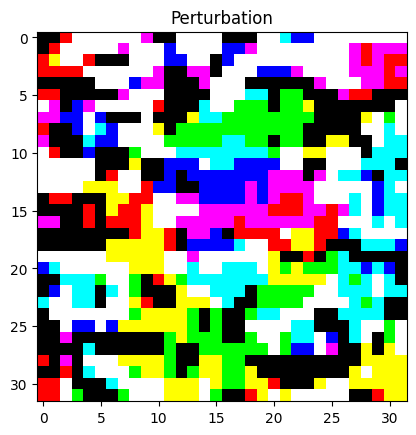

In [ ]:
perturbations = create_adversarial_pattern(x_train[0:1], y_train[0:1], model)
plt.imshow(perturbations[0])
plt.title("Perturbation")
plt.show()

In [ ]:
def PGD_attack(model, image, label, classes, epsilon, iter_eps, iterations):
    adv_image = image
    ncols = 4
    fig, axs = plt.subplots(nrows=math.ceil((iterations+1) / ncols), ncols=ncols, figsize = (10, 8))
    j = 0
    k = 0
    pred = model.predict(adv_image, verbose=0)
    labelx = classes[np.argmax(pred)]
    confidence = np.max(pred)
    axs[j][k].imshow(adv_image[0])
    axs[j][k].set(title=f"Model Prediction: {labelx} ({confidence*100:.2f}%)")
    axs[j][k].grid(False)
    axs[j][k].set_xticks([])
    axs[j][k].set_yticks([])
    for i in range(1, iterations + 1):
        j = i // ncols
        k = i % ncols
        perturbations = create_adversarial_pattern(adv_image, label, model)
        adv_image = adv_image + iter_eps*perturbations
        adv_image = tf.clip_by_value(adv_image, image - epsilon, image + epsilon)
        adv_image = tf.clip_by_value(adv_image, 0, 1)  # ensure valid pixel range
        pred = model.predict(adv_image, verbose=0)
        labelx = classes[np.argmax(pred)]
        confidence = np.max(pred)
        description = labelx
        # decoded =  decoder_pred(pred)
        # description,labelx, confidence = decoded[0][0]
        # print(f"Iteration: {i+1}"+"\n"+f"Epsilon: {iter_eps}"+"\n"+f"Predicted: {labelx} ({confidence*100:.2f}%)")
        axs[j][k].imshow(adv_image[0])
        axs[j][k].set(title=f"Iteration: {i}"+"\n"+f"Predicted: {labelx} ({confidence*100:.2f}%)")
        axs[j][k].grid(False)
        axs[j][k].set_xticks([])
        axs[j][k].set_yticks([])
    fig.tight_layout()
    fig.savefig(os.path.join(tp_data_root, "pgd_attack_cifar10_result.png"))
    plt.show()
    return adv_image

In [ ]:
def PGD_attack_2(model, image, label, classes, epsilon, iter_eps, iterations):
    adv_image = image
    for i in range(iterations):
        perturbations = create_adversarial_pattern(adv_image, label, model)
        adv_image = adv_image + iter_eps*perturbations
        adv_image = tf.clip_by_value(adv_image, image - epsilon, image + epsilon)
        adv_image = tf.clip_by_value(adv_image, 0, 1)  # ensure valid pixel range
        pred = model.predict(adv_image, verbose = 0)
        labelx = classes[np.argmax(pred)]
        confidence = np.max(pred)
        description = labelx
        # decoded =  decoder_pred(pred)
        # description,labelx, confidence = decoded[0][0]
        print(f"Iteration: {i+1}"+"\n"+f"Epsilon: {iter_eps}"+"\n"+f"Predicted: {labelx} ({confidence*100:.2f}%)")
        fig, ax = plt.subplots(figsize=(1,1))
        ax.imshow(adv_image[0])
        ax.set(title=f"Iteration: {i+1}"+"\n"+f"Predicted: {labelx} ({confidence*100:.2f}%)")
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()
    return adv_image



In [ ]:
def plot_prediction(model, input_img, classes):
    pred = model.predict(input_img, verbose = 0)
    labelx = classes[np.argmax(pred)]
    confidence = np.max(pred)
    description = labelx
    fig, ax = plt.subplots()
    ax.imshow(input_img[0])
    ax.set(title=f"Prediction: {labelx} ({confidence*100:.2f}%)")
    ax.grid(False)
    # ax.set_xticks([])
    # ax.set_yticks([])
    plt.show()

In [ ]:
import math

iterations = 7
epsilon = 0.1
iter_eps = 0.02
# savePath='/content/drive/My Drive/saved_img/'
# iter_num = math.ceil(x_train_rgb.shape[0] / batch_size)

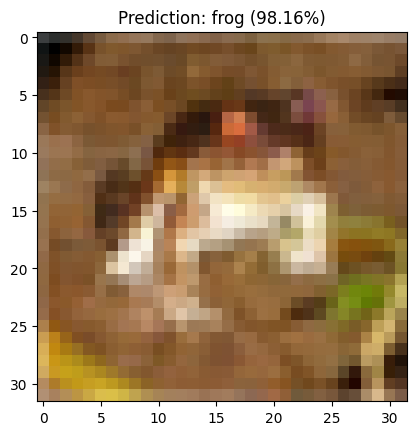

In [ ]:
plot_prediction(model, x_train[0:1], classes)

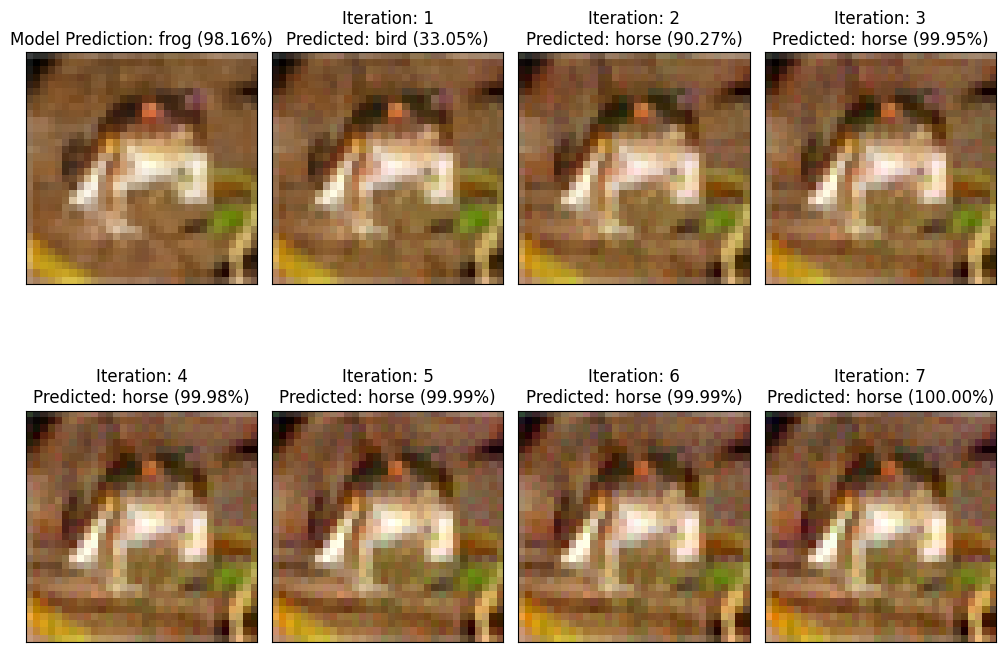

In [ ]:
adv_images = PGD_attack(model, x_train[0:1], y_train[0:1], classes, epsilon, iter_eps, iterations)

Iteration: 1
Epsilon: 0.02
Predicted: bird (33.05%)


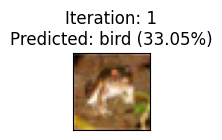

Iteration: 2
Epsilon: 0.02
Predicted: horse (90.27%)


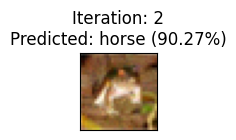

Iteration: 3
Epsilon: 0.02
Predicted: horse (99.95%)


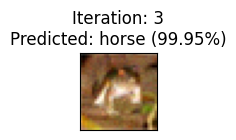

Iteration: 4
Epsilon: 0.02
Predicted: horse (99.98%)


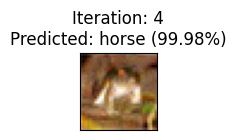

Iteration: 5
Epsilon: 0.02
Predicted: horse (99.99%)


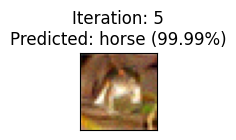

Iteration: 6
Epsilon: 0.02
Predicted: horse (99.99%)


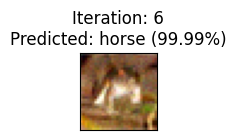

Iteration: 7
Epsilon: 0.02
Predicted: horse (100.00%)


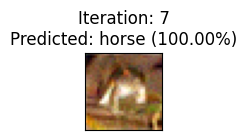

In [ ]:
adv_images_2 = PGD_attack_2(model, x_train[0:1], y_train[0:1], classes, epsilon, iter_eps, iterations)

# References

\[1] Madry, Aleksander. "Towards deep learning models resistant to adversarial attacks." arXiv preprint arXiv:1706.06083 (2017).

\[2] Oscar Knagg, Towards Data Science, https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3